# Compare starting checkpoints

Train the Citation-Integrity dataset on 3 different starting checkpoints to find out which one gives the best results.
Starting checkpoints from MultiVerS are:
- COVIDFact (`covidfact`)
- HealthVer (`healthver`)
- SciFact (`scifact`)

Import the necessary packages including the `eval` package from this repo for reading the data and predictions and calculating metrics:

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns

# Get the current directory and parent directory
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

# Add the parent directory to sys.path
sys.path.append(parent_dir)

# Import eval from the parent directory
import eval

Calculate precision and recall for each combination of checkpoint and dataset

In [2]:
# Start with empty DataFrame
df = pd.DataFrame()
columns = ['SUPPORT', 'REFUTE', 'NEI', 'micro', 'macro']
# Loop over metrics
for metric in ['precision', 'recall']:
    
    # Loop over datasets and checkpoints
    for dataset in ['citint']:
        for checkpoint in ['covidfact', 'healthver', 'scifact']:
            data = eval.read_data(f'../data/{dataset}', 'test')
            predictions = eval.read_predictions(f'../predictions/compare_ckpt/{checkpoint}_{dataset}.jsonl')
            values = eval.calc_metric(data, predictions, metric)
            values_df = pd.DataFrame([values], columns = columns)
            values_df['metric'] = metric
            values_df['dataset'] = dataset
            values_df['checkpoint'] = checkpoint
            df = pd.concat([df, values_df], ignore_index = True)

# Drop micro and macro averages - we'll just look at scores for each label
df = df.drop(columns = ['micro', 'macro'])

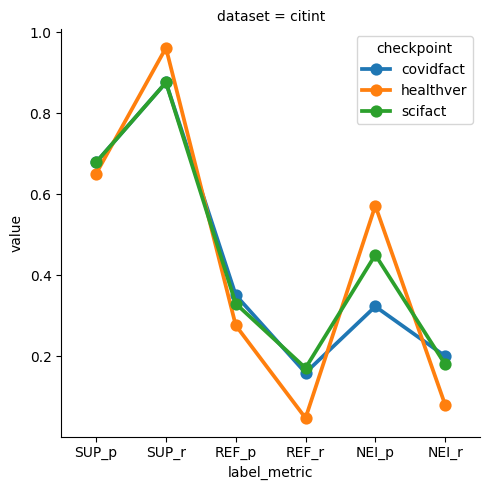

In [3]:
df2 = pd.melt(df, id_vars=['metric', 'dataset', 'checkpoint'], value_name = 'value', var_name = 'label')
# Abbreviate labels and add _p or _r
df2['label_metric'] = df2['label'].str[:3]+'_'+df2['metric'].str[0]
plot_ = sns.catplot(data=df2, col='dataset', x='label_metric', y='value', hue='checkpoint', kind='point', legend_out=False)

## TODO: experiment with rationale_weight

